In [29]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

In [30]:
# load data
def load_data(stats_path, wear_path):
    X = pd.read_csv(stats_path).values
    wear_data = pd.read_csv(wear_path)
    y = wear_data[['flute_1', 'flute_2', 'flute_3']].values
    return X, y

In [31]:
# train lasso model with time series split and multi-output regression and let it select the best fold based on MSE values
def train_lasso_select_fold(X, y, n_splits=5, alpha=0.1, max_iter=10000):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_errors = []
    val_errors = []
    best_fold_index = -1
    best_val_mse = float('inf')
    
    lasso = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=max_iter))
    scaler = StandardScaler()

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # normalize the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # train model
        lasso.fit(X_train_scaled, y_train)
        
        # predict
        y_pred_test = lasso.predict(X_test_scaled)
        
        # calculate MSE to evaluate prediction performance
        mse_val = np.mean((y_test - y_pred_test) ** 2, axis=0).mean()
        mse_train = np.mean((y_train - lasso.predict(X_train_scaled)) ** 2, axis=0).mean()
        
        train_errors.append(mse_train)
        val_errors.append(mse_val)
        
        # Update best fold based on MSE
        if mse_val.mean() < best_val_mse:
            best_val_mse = mse_val.mean()
            best_fold_index = fold  # Assign fold index directly

    return lasso, scaler, train_errors, val_errors, best_fold_index

In [32]:
# prediction based on model
def predict_lasso(lasso, scaler, X):
    X_scaled = scaler.transform(X)
    return lasso.predict(X_scaled)

In [33]:
# plot predictions
def plot_predictions(y_actual, y_pred, title="Wear Prediction", flute_labels=None):
    if flute_labels is None:
        flute_labels = [f'Flute {i+1}' for i in range(y_actual.shape[1])]
    
    plt.figure(figsize=(24, 9))
    plt.title(title, pad=30)
    
    for i in range(y_actual.shape[1]):
        plt.subplot(1, len(flute_labels), i + 1)
        plt.plot(range(len(y_actual)), y_actual[:, i], label='Actual wear', marker='o', linewidth=6.0)
        plt.plot(range(len(y_pred)), y_pred[:, i], label='Predicted wear', marker='x', linewidth=2.0)
        plt.title(flute_labels[i])
        plt.xlabel('Test sample', labelpad=15)
        plt.ylabel('Wear Measurement')
        plt.legend()
        plt.xticks(rotation=70)
    
    plt.tight_layout(pad=3.0)
    plt.show()

In [34]:
# Function to plot MSE during cross-val
def plot_mse(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_errors) + 1), train_errors, label='Training MSE', marker='o')
    plt.plot(range(1, len(val_errors) + 1), val_errors, label='Validation MSE', marker='x')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error (MSE) per Fold')
    plt.legend()
    plt.grid(True)
    plt.show()


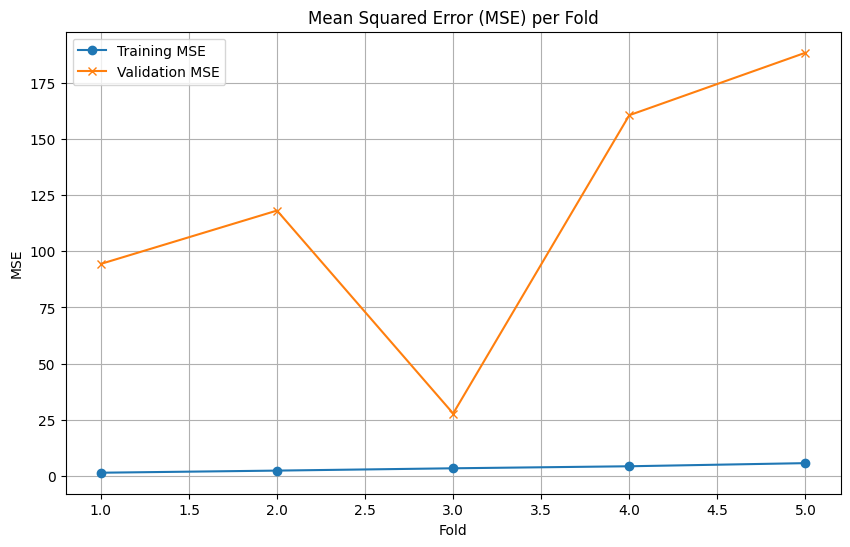

Best fold selected: 3 with validation MSE: 27.74239016326031


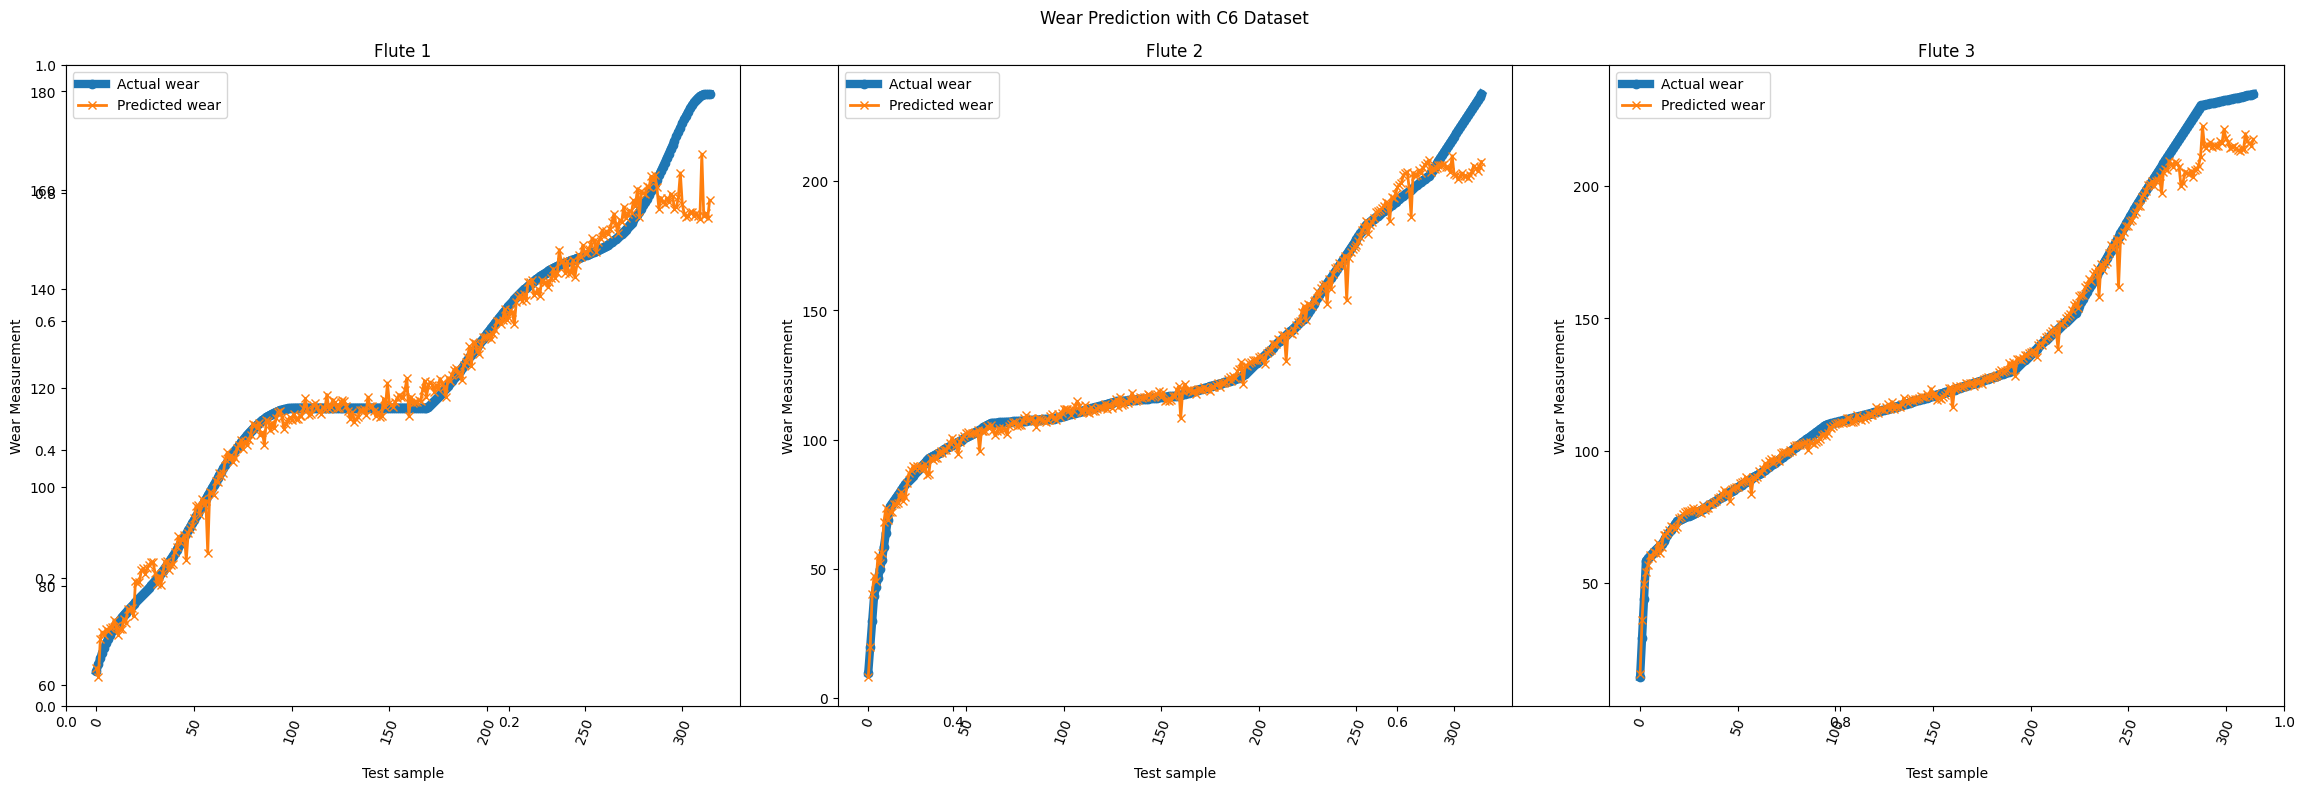

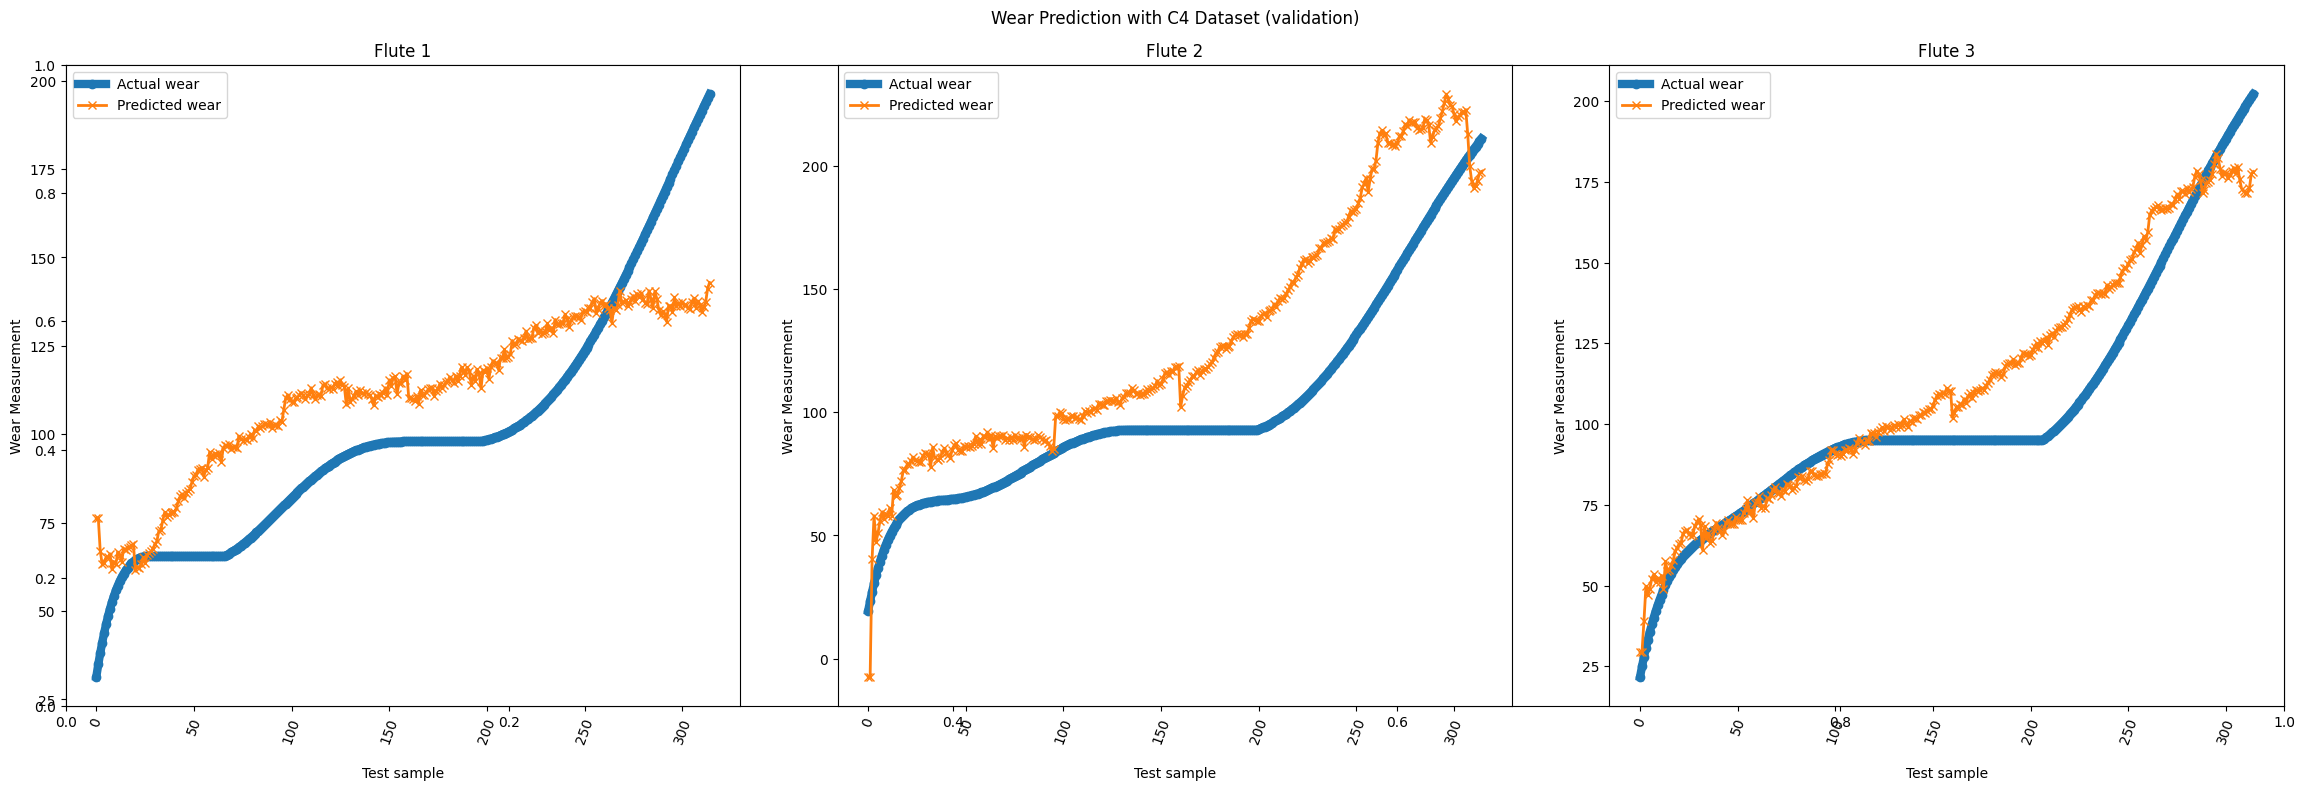

In [35]:
# execution
if __name__ == "__main__":
    # load C1 data
    X, y = load_data('./correlation_files/c6_stats.csv', './data/raw/c6/c6_wear.csv')
    
    # train model using time series split and multi-output regressionm then select best fold
    best_lasso, scaler, train_errors, val_errors, best_fold_index = train_lasso_select_fold(X, y)


    # plot MSE
    plot_mse(train_errors, val_errors)

    # Ensure best_fold_index is an integer
    print(f"Best fold selected: {best_fold_index + 1} with validation MSE: {min(val_errors)}")

    # Make predictions
    y_pred = predict_lasso(best_lasso, scaler, X)

    # Plot predictions for C6 data
    plot_predictions(y, y_pred, title="Wear Prediction with C6 Dataset")

    # Validate model with c4 data
    X_c4, y_c4 = load_data('../notebooks/correlation_files/c4_stats.csv', '../notebooks/data/raw/c4/c4_wear.csv')
    y_c4_pred = predict_lasso(best_lasso, scaler, X_c4)
    
    # Plot predictions for c4 data
    plot_predictions(y_c4, y_c4_pred, title="Wear Prediction with C4 Dataset (validation)")